# 95-865 Homework 3

Your name: Ruixin Huang

Your Andrew ID: ruixinh

Collaborators (if none, say \"none\"; do *not* leave this blank): none

# Part 1: Email spam classification [45 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

### Print the number of ham and spam emails [1 point]
 
In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it?

In [45]:
#your code here
import glob
sumHamDocs = 0
sumSpamDocs = 0
for i in glob.glob('./email-data/ham/*.txt'):
    sumHamDocs += 1
for i in glob.glob('./email-data/spam/*.txt'):
    sumSpamDocs += 1
print("the number of emails in ham: ",sumHamDocs)
print("the number of emails in spam: ",sumSpamDocs)

the number of emails in ham:  1500
the number of emails in spam:  3671


### Construct the documents [4 points]
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [46]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [51]:
#your code here
import numpy as np
import glob
doc = []
index = []
for f in glob.glob('./email-data/ham/*.txt'):
    doc.append(makeWordList(f))
    index.append(0)
for f in glob.glob('./email-data/spam/*.txt'):
    doc.append(makeWordList(f))
    index.append(1)
index=np.array(index)

### Construct the document matrix `X` as a matrix of word frequencies [5 points]

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [52]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', min_df=50, max_df=0.8)
X = vectorizer.fit_transform(doc).toarray()
list = vectorizer.get_feature_names()
print("the size of the vocabulary is: ",len(list))

the size of the vocabulary is:  1680


### k-NN, SVM, random forest: Hyperparameter selection [15 points]

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric.

   - k-NN: Select `k` from a range of values of your choice.
   - SVM: (SVC) Select `C` from a range of your choice, use any kernel that performs well.
   - Random forest: Select `n_estimators` **and** `max_depth` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_alpha` and `best_C` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [5]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

num_folds = 5
k_fold = KFold(num_folds,shuffle=True)
param_values = np.logspace(-4, 2, 3)

arg_max = None
max_cross_val_score = -np.inf
for C in param_values:
    # your code to train and score the training data here
    fold_scores = []
    for train, val in k_fold.split(X,index):
        clf = svm.SVC(kernel='rbf', C=C)
        clf.fit(X[train],index[train])
        ypred = clf.predict(X[val])
        yval = index[val]
        accuracy = f1_score(yval, ypred, average='weighted') 
        fold_scores.append(accuracy)        
    cross_val_score = np.mean(fold_scores)
    print('C:', C, 'fold score is:', cross_val_score)
    if cross_val_score > max_cross_val_score:
        max_cross_val_score = cross_val_score
        arg_max = C
            
best_C = arg_max
print("the best_C is: ",best_C)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C: 0.0001 fold score is: 0.5895281440547744
C: 0.1 fold score is: 0.6805487000705057
C: 100.0 fold score is: 0.7824994628481129
the best_C is:  100.0


In [14]:
from sklearn.neighbors import KNeighborsClassifier   
arg_max = None
num_folds = 5
k_fold = KFold(num_folds,shuffle=True)
max_cross_val_score = -np.inf
for k in range(1, 50):
    fold_scores = []
    for train, val in k_fold.split(X,index):
        classifier = KNeighborsClassifier(n_neighbors=k) 
        classifier.fit(X[train], index[train])
        ypred = clf.predict(X[val])
        yval = index[val]
        accuracy = f1_score(yval, ypred, average='weighted') 
        fold_scores.append(accuracy)        
    cross_val_score = np.mean(fold_scores)
    print('k:', k, 'cross validation score is:', cross_val_score)    
    if cross_val_score > max_cross_val_score:
        max_cross_val_score = cross_val_score
        arg_max = k
            
best_k = arg_max
print("the best_k is: ",best_k)

k: 1 cross validation score is: 0.9947679894438947
k: 2 cross validation score is: 0.9947670765489717
k: 3 cross validation score is: 0.9947682679209386
k: 4 cross validation score is: 0.9947675190103601
k: 5 cross validation score is: 0.9947687451687575
k: 6 cross validation score is: 0.9947681399857198
k: 7 cross validation score is: 0.9947692061657915
k: 8 cross validation score is: 0.9947671237204039
k: 9 cross validation score is: 0.9947676823085185
k: 10 cross validation score is: 0.994768473640459
k: 11 cross validation score is: 0.9947676632692017
k: 12 cross validation score is: 0.9947643139720823
k: 13 cross validation score is: 0.9947663273490809
k: 14 cross validation score is: 0.9947682521017136
k: 15 cross validation score is: 0.9947688229982721
k: 16 cross validation score is: 0.9947679602916247
k: 17 cross validation score is: 0.9947666000771068
k: 18 cross validation score is: 0.9947669199628862
k: 19 cross validation score is: 0.9947688167651055
k: 20 cross validation

In [17]:
from sklearn.ensemble import RandomForestClassifier
num_folds = 5
k_fold = KFold(n_splits=num_folds, shuffle=True)
max_cross_val_score = -np.inf
for n in [20,40,60,80,100,120,140]:
    fold_scores = []
    for train, val in k_fold.split(X,index):
        classifier = RandomForestClassifier(n_estimators = n,random_state = 0)
        classifier.fit(X[train], index[train])
        ypred = clf.predict(X[val])
        yval = index[val]
        accuracy = f1_score(yval, ypred, average='weighted') 
        fold_scores.append(accuracy)
    cross_val_score = np.mean(fold_scores)
    print('estimator:', n, 'cross validation score is:', cross_val_score)    
    if cross_val_score > max_cross_val_score:
        max_cross_val_score = cross_val_score
        arg_max = n
        
best_n_estimators = arg_max
print("the best_n_estimator is: ",best_n_estimators)

estimator: 20 cross validation score is: 0.9947673959705977
estimator: 40 cross validation score is: 0.9947674624199662
estimator: 60 cross validation score is: 0.994768118659942
estimator: 80 cross validation score is: 0.9947687084108494
estimator: 100 cross validation score is: 0.9947663714678268
estimator: 120 cross validation score is: 0.9947681417092653
estimator: 140 cross validation score is: 0.9947668269081087
the best_n_estimator is:  80


In [18]:
num_folds = 5
k_fold = KFold(n_splits=num_folds, shuffle=True)
max_cross_val_score = -np.inf
for d in [10,20,30,40,50,60,70,80,90,100]:
    fold_scores = []
    for train, val in k_fold.split(X,index):
        classifier = RandomForestClassifier(max_depth = d,random_state = 0)
        classifier.fit(X[train], index[train])
        ypred = clf.predict(X[val])
        yval = index[val]
        accuracy = f1_score(yval, ypred, average='weighted') 
        fold_scores.append(accuracy)
    cross_val_score = np.mean(fold_scores)
    print('max_depth:', d, 'cross validation score is:', cross_val_score) 
    if cross_val_score > max_cross_val_score:
        max_cross_val_score = cross_val_score
        arg_max = d
max_depth = arg_max
print("the max_depth is: ",max_depth)

max_depth: 10 cross validation score is: 0.9947680913334999
max_depth: 20 cross validation score is: 0.9947673155063071
max_depth: 30 cross validation score is: 0.9947684067077368
max_depth: 40 cross validation score is: 0.9947605728659529
max_depth: 50 cross validation score is: 0.9947680850491848
max_depth: 60 cross validation score is: 0.9947635670199837
max_depth: 70 cross validation score is: 0.9947665289651276
max_depth: 80 cross validation score is: 0.9947678114091714
max_depth: 90 cross validation score is: 0.9947666192383388
max_depth: 100 cross validation score is: 0.9947675705781274
the max_depth is:  30


### Classifier testing: Precision-Recall and ROC curves [20 points]

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the training data.
   - Use test emails to in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 3 ROC curves, one for each classifier.
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 3 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

In [61]:
#your code here
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
test_data = glob.glob('./email-data/testing/*.txt')
doc_test = []
index_test = []
for doc in test_data:
    doc_test.append(makeWordList(doc))
    if "ham" in doc:
        state = 0
    else:
        state = 1
    index_test.append(state)
doc_test_need = vectorizer.transform(doc_test).toarray()
index_test = np.array(index_test)

In [64]:
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(X, index)
predicted_knn = knn_classifier.predict(doc_test_need)
probability_knn = knn_classifier.predict_proba(doc_test_need)[:, 1]

svm_classifier = svm.SVC(C=best_C,probability = True)
svm_classifier.fit(X, index)
predicted_svm = svm_classifier.predict(doc_test_need)
probability_svm = svm_classifier.predict_proba(doc_test_need)[:, 1]

rf_classifier = RandomForestClassifier(n_estimators = best_n_estimators,max_depth=max_depth)
rf_classifier.fit(X, index)
predicted_rf = rf_classifier.predict(doc_test_need)
probability_rf = rf_classifier.predict_proba(doc_test_need)[:, 1]

knn_fpr, knn_tpr, threshold = roc_curve(index_test, probability_knn)
knn_roc_auc = auc(knn_fpr, knn_tpr)

svm_fpr, svm_tpr, threshold = roc_curve(index_test, probability_svm)
svm_roc_auc = auc(svm_fpr, svm_tpr)

rf_fpr, rf_tpr, threshold = roc_curve(index_test, probability_rf)
rf_roc_auc = auc(rf_fpr, rf_tpr)

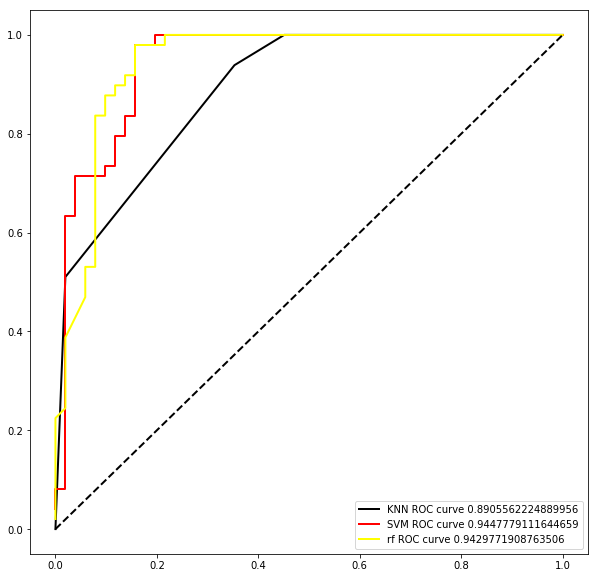

In [67]:
plt.figure(figsize = (10, 10))
plt.plot(knn_fpr, knn_tpr, linestyle='-', color = "black", lw = 2, label = "KNN ROC curve {}".format(knn_roc_auc))
plt.plot(svm_fpr, svm_tpr, linestyle='-', color = "red", lw = 2, label = "SVM ROC curve {}".format(svm_roc_auc))
plt.plot(rf_fpr, rf_tpr, linestyle='-', color = "yellow", lw = 2, label = "rf ROC curve {}".format(rf_roc_auc))
plt.plot([0,1], [0, 1], color = "black", lw = 2, linestyle = "--")
plt.legend()
plt.show()

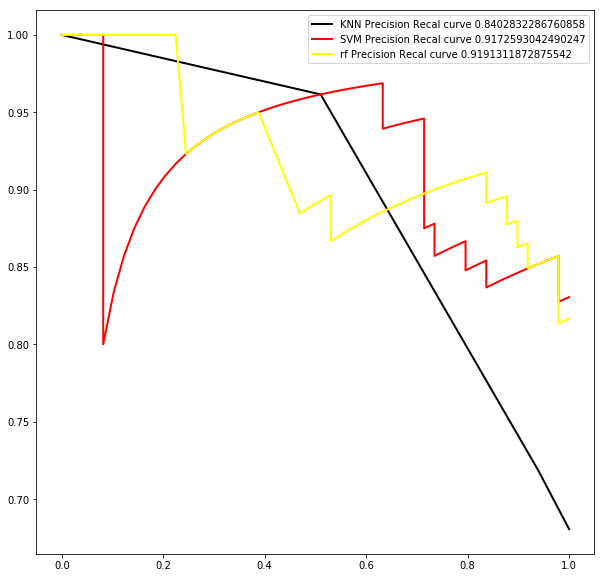

In [68]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
knn_precision, knn_recall, threshoulds = precision_recall_curve(index_test,probability_knn)
svm_precision, svm_recall, threshoulds = precision_recall_curve(index_test,probability_svm)
rf_precision, rf_recall, threshoulds = precision_recall_curve(index_test,probability_rf)
knn_ap = average_precision_score(index_test,probability_knn)
svm_ap = average_precision_score(index_test,probability_svm)
rf_ap = average_precision_score(index_test,probability_rf)
plt.figure(figsize = (10, 10))
plt.plot(knn_recall, knn_precision, linestyle='-', color = "black", lw = 2, label = "KNN Precision Recal curve {}".format(knn_ap))
plt.plot(svm_recall, svm_precision, linestyle='-', color = "red", lw = 2, label = "SVM Precision Recal curve {}".format(svm_ap))
plt.plot(rf_recall, rf_precision, linestyle='-', color = "yellow", lw = 2, label = "rf Precision Recal curve {}".format(rf_ap))
plt.legend()
plt.show()

In [ ]:
Of the ROC and Precision-Recall curves, which one would you use for this task and why?
I will choose ROC because in this task the sample is much more similar.
Which classifier is the best, according to your chosen curves?
RandomForest is the best,because its score is higher than others.

# Part 2: Image Segmentation [50 points]

### What is segmentation?

Segmentation is the task of "labeling" groups of pixels in an image to identify certain objects.

In the early years, research on segmentation was focused on "foreground-background" segmentation; marking only those pixels that comprise the "background" of an image (in the image below, the background is marked in blue).

<div>
<img src="http://www.eyeshalfclosed.com/images/cat.jpg" width=500/>
</div>

In recent years, sophisticated deep-learning models have enabled complex multi-label segmentation, such as in the images below.

<tr>
<td>
<img src="http://www.eyeshalfclosed.com/images/sheep.png" width=500/>
</td>
<td>
<img src="http://www.eyeshalfclosed.com/images/street.png" width=500/>
</td>
</tr>
   

### Prerequisites [20 points]

You get 20 points for setting up AWS and successfully running the code given in the following sections.

This homework needs to be run on an AWS GPU instance; it will not complete in time without a GPU. Look up the relevant documentation to set up an AWS machine as configured below.

**Machine.**

   - Use the [Ubuntu Deep Learning AMI](https://aws.amazon.com/marketplace/pp/B077GCH38C).
   - Use a p2.xlarge instance.
   - Allocate at least 80GB of disk space.
   - Use the `conda_tensorflow_p36` Conda environment: `source activate tensorflow_p36`
   - Create a security group and open all inbound/outbound ports to 0.0.0.0/0.

All commands below assume the aforementioned Conda environment is active.

**Run Jupyter.** `jupyter notebook --ip=* --no-browser`

You may move Jupyter to the background by: CTRL-Z, then `bg`, then `disown`. You can access Jupyter using your public DNS; it will look something like `ec2-54-84-36-171.compute-1.amazonaws.com:8888`. Figure out how you can find this out.

**Data downloads.** All downloads must go into the same directory as this notebook. Unzip files after download. *This will take time.*

   * Download the [trained model weights](https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5) (~250MB).

   * Download the [training images](http://images.cocodataset.org/zips/train2014.zip) (13GB).
   
   * Download the [validation images](http://images.cocodataset.org/zips/val2014.zip) (6GB).
   * Download the [training image annotations](https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0).
   * Download the [test image annotations](https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0).

Now create a new folder named `2014`, then move the `train2014`, `val2014` folders into `2014/`.

Create a new `2014/annotations/` folder and move the train and test annotation JSON files into it

Your directory structure should look like:
```
2014/
   /annotations/
       /annotations/instances_minival2014.json
       /annotations/instances_valminusminival2014.json
   /train2014/
       /train2014/*.jpg
   /val2014/
       /val2014/*.jpg
```

**Package installation.**

   * Install Cython: `pip install cython`
   * Install Tensorflow: `pip install tensorflow==1.3.0 tensorflow-gpu==1.3.0`
   * Install Keras and image tools: `pip install keras scikit-image pillow h5py`
   * Install OpenCV: `pip install opencv-python`
   * Install pycoco:
   
`pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"`
   
**GPU.** Ensure Keras/TensorFlow can see your GPU with the following Python code (run in the `conda_tensorflow_p36 environment` after installing all the required packages). You should see a GPU in one of the devices listed.

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 471677074722064101
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15798195824132849677
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


### Testing a pre-trained model on small data

We will first load a pre-trained convolutional neural network model and test it on a small dataset of images. These images are stored in the `/images/` folder.

The model was trained by annotating each image with the objects it contains. Annotations are in the following format:

```
annotation{
    "id" : int,
    "image_id" : int,
    "category_id" : int,
    "segmentation" : RLE or [polygon],
    "area" : float,
    "bbox" : [x,y,width,height],
    "iscrowd" : 0 or 1,
}

categories[{
    "id" : int,
    "name" : str,
    "supercategory" : str,
}]
```

Make sure you understand the annotations and how they are connect to images by looking at [section 4 on this page](http://cocodataset.org/#download). You may ignore the `iscrowd` variable.

### Set up the environment

In [69]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
from model import log
import visualize
from config import Config
from shapes import ShapesDataset

from pycocotools.coco import COCO

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pycocotools/coco.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fil

### Model configuration

These lines specify how many GPUs to use, and how many images to process in parallel on each GPU.

In [70]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

### Load the pre-trained model

This is actually a Keras model wrapped along with some helpful functions. The model may be loaded in two modes: `training` and `inference` (testing) mode. `model_dir` points towards a directory to save logs and trained weights, which we have set above as the `/logs` directory.

In [71]:
%%time
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

CPU times: user 8.76 s, sys: 720 ms, total: 9.48 s
Wall time: 12.5 s


### Hard-code object classes

For the small dataset of images we are using, we define our own list of class names and class indices for each object. These are of various types: for example, "car", "bicycle", etc..

In [72]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### Load and visualize a random image

Make sure you understand what the code below is doing.

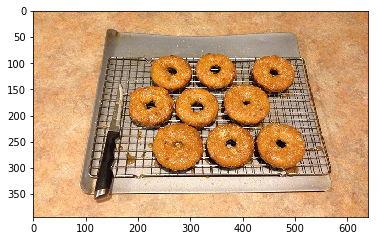

In [81]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
plt.imshow(image)
plt.show()

### Test the pre-trained model

We now call the `detect` function of the model on the list of images we want to be segmented. This returns a `result` object; inspect this object to see what it contains.

The `visualize` helper module provides useful functions to visualize our segmentation results. Understand how this function works (SHIFT+TAB in Jupyter is useful, as well as looking at the code in `visualize.py` directly).

Processing 1 images
image                    shape: (394, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
CPU times: user 320 ms, sys: 24 ms, total: 344 ms
Wall time: 803 ms


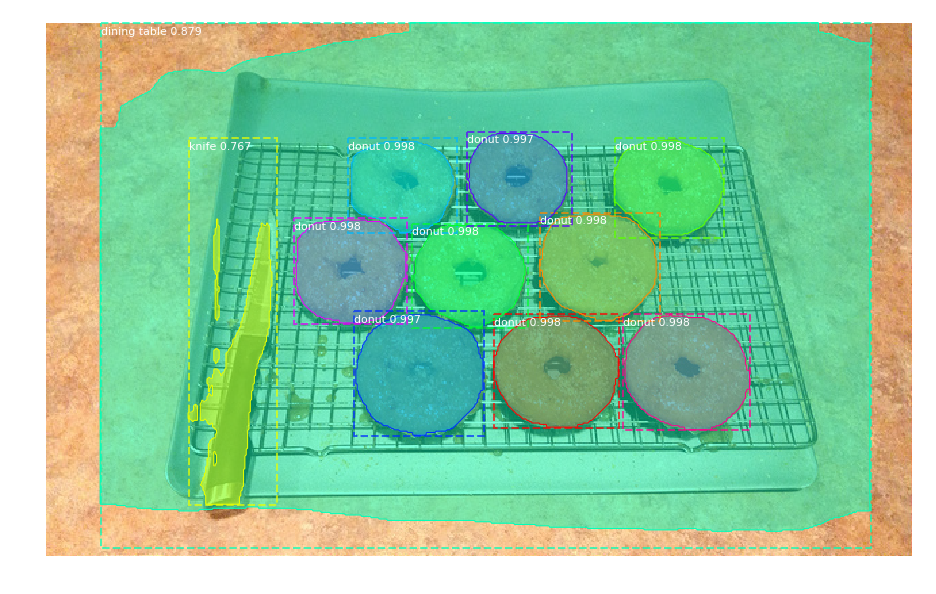

In [82]:
%%time
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Training from scratch

Now that we understand what a properly trained model should do, we consider training a model from scratch.

### Load the data

Load the annotations for the training images into memory.

In [83]:
%%time
config = coco.CocoConfig()
COCO_DIR = "2014"
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "minival")
dataset.prepare()

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
CPU times: user 576 ms, sys: 24 ms, total: 600 ms
Wall time: 597 ms


Now load the same for the test images.

In [84]:
%%time
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val35k")
dataset_val.prepare()

loading annotations into memory...
Done (t=3.92s)
creating index...
index created!
CPU times: user 5.5 s, sys: 124 ms, total: 5.62 s
Wall time: 5.6 s


### List a few object classes

In [85]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    if i > 10:
        break

Image Count: 4952
Class Count: 81
  0. BG                                                
  1. person                                            
  2. bicycle                                           
  3. car                                               
  4. motorcycle                                        
  5. airplane                                          
  6. bus                                               
  7. train                                             
  8. truck                                             
  9. boat                                              
 10. traffic light                                     
 11. fire hydrant                                      


### Visualize a random image and its annotations

image_id  2958 http://cocodataset.org/#explore?id=398203
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000
mask                     shape: (427, 640, 13)        min:    0.00000  max:    1.00000
class_ids                shape: (13,)                 min:    1.00000  max:   33.00000
bbox                     shape: (13, 4)               min:    0.00000  max:  640.00000


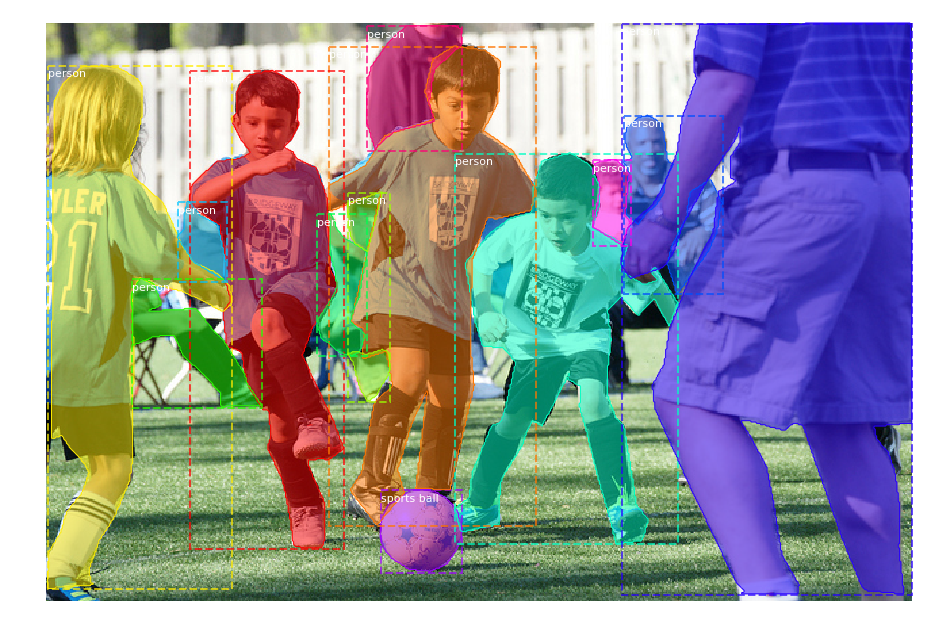

In [86]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Training configuration

See the default configuration values in `config.py`.

In [87]:
class TrainConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 60

config = TrainConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING     

### Create a new model in training mode [5 points]

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

### Initialize the model weights with the weights learned on COCO [5 points]

Call `load_weights` as before, but add the following argument in the call to the function:

```
exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"]
```

In [16]:
# your code here
model.load_weights(filepath=COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

### Train the model for 10 epochs [5 points]

Look up the documentation or code for the train function to figure out its arguments.

Pass the following additional arguments to the `train` function:

   - `layers="heads"` to only train the weights that were not pre-loaded.
   - `learning_rate=config.LEARNING_RATE` to set the learning rate.
   - `epochs=10`.
   
This will take ~10 minutes on a p2.xlarge GPU instance with 1 GPU.

In [17]:
%%time
# call to train
model.train(dataset, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')


Starting at epoch 0. LR=0.002

Checkpoint Path: /home/ubuntu/HW3/logs/coco20181205T1427/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


60/60 [==============================] - 70s 1s/step - loss: 3.5147 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.3073 - mrcnn_class_loss: 1.5191 - mrcnn_bbox_loss: 0.8256 - mrcnn_mask_loss: 0.8407 - val_loss: 2.7230 - val_rpn_class_loss: 0.0075 - val_rpn_bbox_loss: 0.2535 - val_mrcnn_class_loss: 1.1074 - val_mrcnn_bbox_loss: 0.6741 - val_mrcnn_mask_loss: 0.6805
Epoch 2/10
60/60 [==============================] - 53s 880ms/step - loss: 2.3438 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3176 - mrcnn_class_loss: 0.8321 - mrcnn_bbox_loss: 0.5948 - mrcnn_mask_loss: 0.5862 - val_loss: 2.1232 - val_rpn_class_loss: 0.0064 - val_rpn_bbox_loss: 0.4042 - val_mrcnn_class_loss: 0.6479 - val_mrcnn_bbox_loss: 0.4447 - val_mrcnn_mask_loss: 0.6200
Epoch 3/10
60/60 [==============================] - 54s 896ms/step - loss: 2.4411 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.4302 - mrcnn_class_loss: 0.8199 - mrcnn_bbox_loss: 0.5541 - mrcnn_mask_loss: 0.6145 - val_loss: 1.9969 - val_rpn_class_loss: 0.0059 - 

### Visualize learning progress with TensorBoard [5 points]

   - Start Tensorboard with `tensorboard --logdir=logs/` in the same folder as the notebook:
```
TensorBoard 0.1.8 at http://ip-172-31-27-18:6006 (Press CTRL+C to quit)
```

   - Connect to `public_dns:6006` where `public_dns` is your public DNS.
   - Click on the "Scalars" tab at the top of the page.
   - Include a screenshot of the overall loss vs. number of epochs below this line (store the image in the same folder as the notebook as "yourloss.png".
   
 <img src="yourloss.png"/>

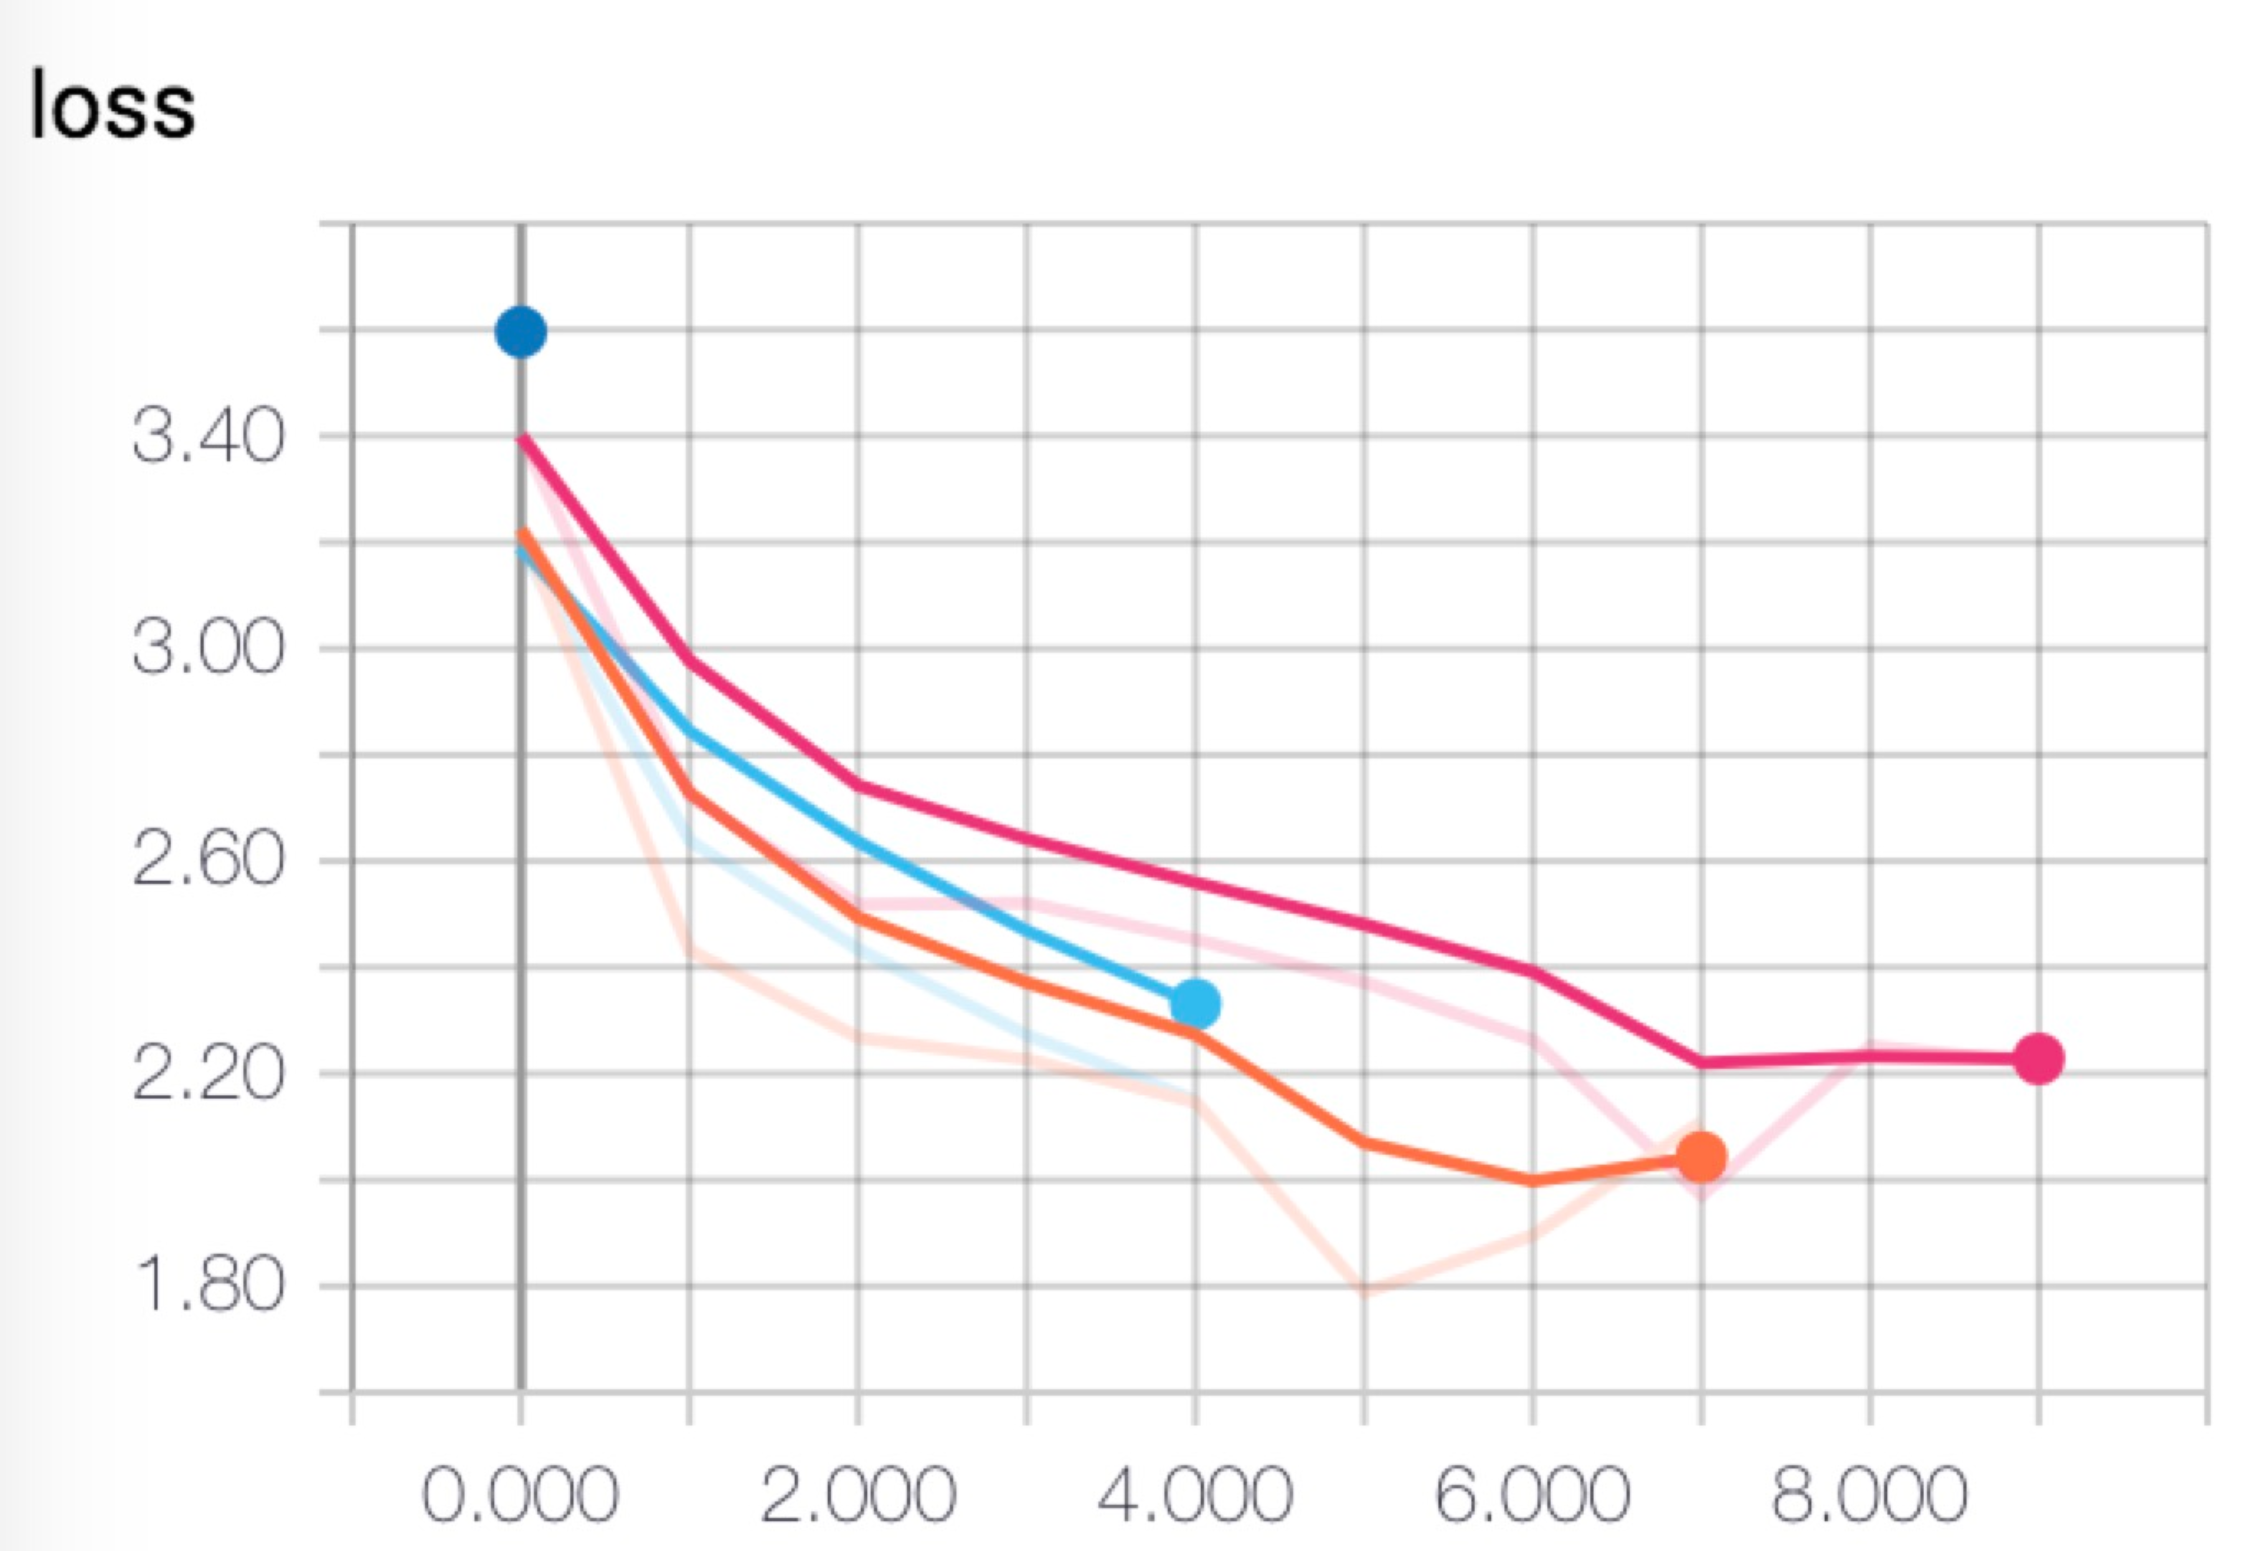

### Test model [10 points]

Load the model in inference (testing) mode.

In [18]:
# load model
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()     #no change???

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Load the last trained model weights.

In [19]:
model_path = model.find_last()[1] # use the last trained weights
model.load_weights(model_path, by_name=True)

Visualize the true annotations of a random test image.

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (89,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (1, 4)                min:  267.00000  max:  813.00000
gt_bbox                  shape: (1, 4)                min:  267.00000  max:  813.00000
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000


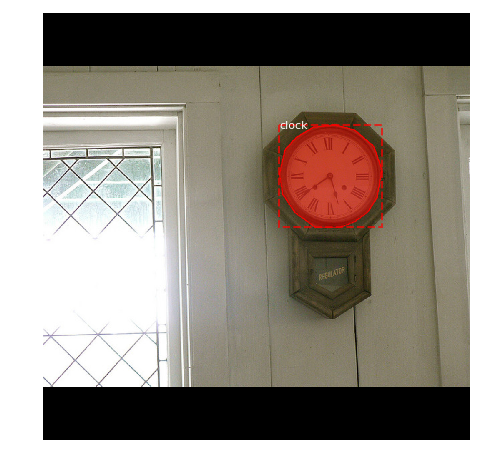

In [20]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Visualize the predicted annotations for this image

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000

*** No instances to display *** 



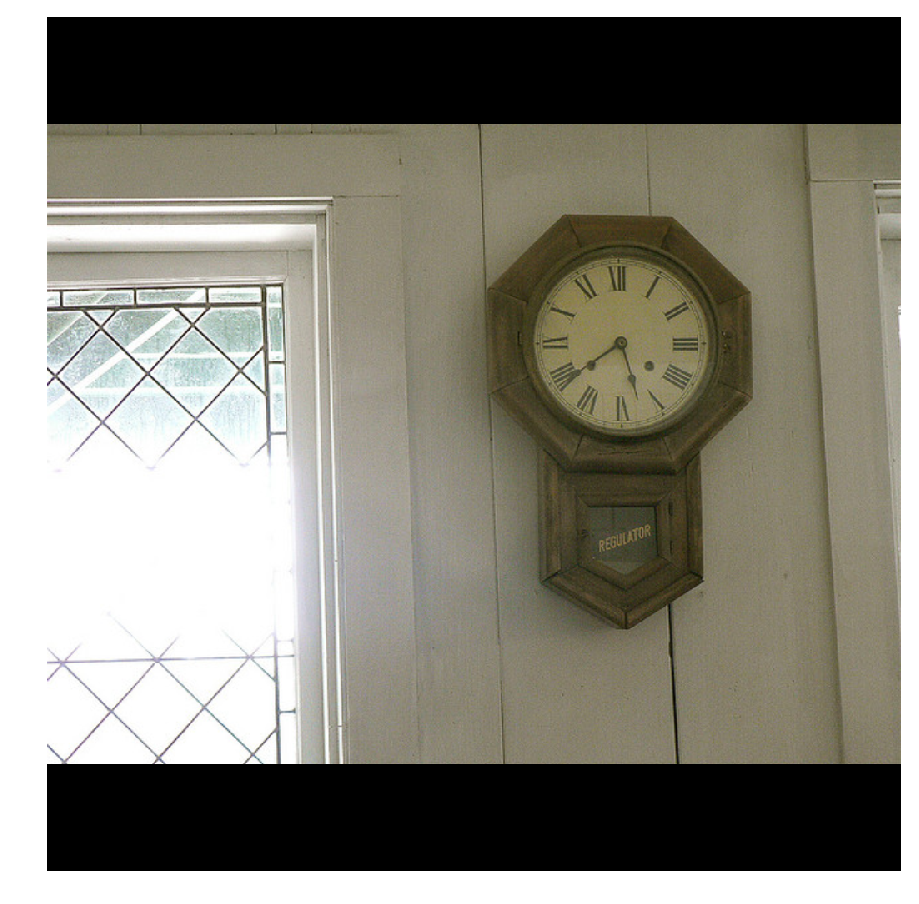

In [21]:
# prediction function call and visualization
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

# Part 3: Sentiment Analysis [50 points]

Download data from: https://www.dropbox.com/s/ouhiwmzodc4baob/HW3-data-Sentiment.zip?dl=0 <br>

The folder contains:

- Train.csv
- test.csv

### Read the training data  [5 Points]

Read the data present in training.csv file. **Please do no change the file name and use relative path, i.e. './HW3-data/train.csv'** <br>
Perform the following cleaning on the data:
1. Keep only the Sentiment and sentiment text in the dataframe - the first and the last coumn
2. Some of the sentiments and sentiment texts are empty. Remove those rows.
3. Shuffle the rows of the data frame such that the positive and negative tweets are mixed
4. Print the first 5 sentiments.
5. Print the number of positive and negative sentiments

In [14]:
# your code here
import pandas as pd
dataOriginal = pd.read_csv('./HW3-data/train.csv',encoding = 'iso-8859-1')
dataOriginal.columns=['A','B','C','D','E','F']

In [15]:
dataOriginal.drop(['B','C','D','E'],axis = 1, inplace = True)

In [16]:
dataOriginal.dropna()

A                                                  F
0        0  is upset that he can't update his Facebook by ...
1        0  @Kenichan I dived many times for the ball. Man...
2        0    my whole body feels itchy and like its on fire 
3        0  @nationwideclass no, it's not behaving at all....
4        0                      @Kwesidei not the whole crew 
5        0                                        Need a hug 
6        0  @LOLTrish hey  long time no see! Yes.. Rains a...
7        0               @Tatiana_K nope they didn't have it 
8        0                          @twittera que me muera ? 
9        0        spring break in plain city... it's snowing 
10       0                         I just re-pierced my ears 
11       0  @caregiving I couldn't bear to watch it.  And ...
12       0  @octolinz16 It it counts, idk why I did either...
13       0  @smarrison i would've been the first, but i di...
14       0  @iamjazzyfizzle I wish I got to watch it with ...
15       0  Hollis' death scene will hurt me severely to w...
16       0                               about to file taxes 
17       0  @LettyA ahh ive always wanted to see rent  lov...
18       0  @FakerPattyPattz Oh dear. Were you drinking ou...
19       0  @alydesigns i was out most of the day so didn'...
20       0  one of my friend called me, and asked to meet ...
21       0   @angry_barista I baked you a cake but I ated it 
22       0             this week is not going as i had hoped 
23       0                         blagh class at 8 tomorrow 
24       0     I hate when I have to call and wake people up 
25       0  Just going to cry myself to sleep after watchi...
26       0                             im sad now  Miss.Lilly
27       0  ooooh.... LOL  that leslie.... and ok I won't ...
28       0  Meh... Almost Lover is the exception... this t...
29       0  some1 hacked my account on aim  now i have to ...
...     ..                                                ...
1599969  1  Thanks @eastwestchic &amp; @wangyip Thanks! Th...
1599970  1  @marttn thanks Martin. not the most imaginativ...
1599971  1          @MikeJonesPhoto Congrats Mike  Way to go!
1599972  1  http://twitpic.com/7jp4n - OMG! Office Space.....
1599973  1  @yrclndstnlvr ahaha nooo you were just away fr...
1599974  1  @BizCoachDeb  Hey, I'm baack! And, thanks so m...
1599975  1  @mattycus Yeah, my conscience would be clear i...
1599976  1  @MayorDorisWolfe Thats my girl - dishing out t...
1599977  1                          @shebbs123 i second that 
1599978  1                                     In the garden 
1599979  1  @myheartandmind jo jen by nemuselo zrovna tÃ© ...
1599980  1  Another Commenting Contest! [;: Yay!!!  http:/...
1599981  1  @thrillmesoon i figured out how to see my twee...
1599982  1  @oxhot theri tomorrow, drinking coffee, talkin...
1599983  1  You heard it here first -- We're having a girl...
1599984  1  if ur the lead singer in a band, beware fallin...
1599985  1              @tarayqueen too much ads on my blog. 
1599986  1  @La_r_a NEVEER  I think that you both will get...
1599987  1  @Roy_Everitt ha- good job. that's right - we g...
1599988  1                 @Ms_Hip_Hop im glad ur doing well 
1599989  1                              WOOOOO! Xbox is back 
1599990  1  @rmedina @LaTati Mmmm  That sounds absolutely ...
1599991  1                  ReCoVeRiNg FrOm ThE lOnG wEeKeNd 
1599992  1                                  @SCOOBY_GRITBOYS 
1599993  1  @Cliff_Forster Yeah, that does work better tha...
1599994  1  Just woke up. Having no school is the best fee...
1599995  1  TheWDB.com - Very cool to hear old Walt interv...
1599996  1  Are you ready for your MoJo Makeover? Ask me f...
1599997  1  Happy 38th Birthday to my boo of alll time!!! ...
1599998  1  happy #charitytuesday @theNSPCC @SparksCharity...

[1599999 rows x 2 columns]

In [17]:
from sklearn.utils import shuffle
dataNeed = shuffle(dataOriginal)

In [18]:
print(dataNeed.iloc[:][0:5])

         A                                                  F
1362282  1                           @mitchelmusso i love it 
285053   0  i hate that everyone is watching #E3 while im ...
289188   0    @druspencer I did not you ! You should be here 
743033   0        I wish I was going to new york with my Dad 
1465814  1  Robbie is getting married today! holy mother  ...


In [19]:
countN = 0
countP = 0
dataState = dataNeed.iloc[:,0]
arrs = dataState.values
for i in arrs:
    if(i == 0):
        countN +=1
    if(i == 1):
        countP +=1
print("positive sentiments numbers:", countP)
print("negative sentiments numbers:", countN)

positive sentiments numbers: 800000
negative sentiments numbers: 799999


### Data Preparation [10 points]

Before building a neural network model, we first need to prepare the data. The input to a RNN model  is a matrix with shape (a, b), where a is the number of samples (twitters), and b is the sequence length of each tweet. Prepare the data with the following steps:

1\. Take the RAW texts of the top 5000 tweets in the dataframe, and convert them to a list of strings, where each string is a tweet. [1 pt]

In [20]:
# your code here
import numpy as np
rawFrame = dataNeed.iloc[:5000,1:2]
train_data = np.array(rawFrame)
train_list = train_data.tolist()

2\. Use `Tokenizer` from `keras.preprocessing.text` to tokenize the texts and convert them to sequences (numbers) with `texts_to_sequences` method of `Tokenizer`. **When tokenizing, please only consider the top 10,000 words in the dataset (`num_words`=10,000)**. [4 pts]

In [21]:
# your code here

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_list)
sequences = tokenizer.texts_to_sequences(train_list)

3\. Use `pad_sequences` from `keras.preprocessing.sequence` to pad each sequence with zeros to **make the sequence length 120**. [2 pts]

In [22]:
# your code here
from keras.preprocessing.sequence import pad_sequences
padding_sequence = pad_sequences(sequences,maxlen=120)

4\. Split the above data (the sequence and the label) into training (67%) and validation (33%) sets. [3 pts]

In [23]:
# your code here
from keras.datasets import imdb
from keras.preprocessing import sequence
array_label = np.array(dataState)
list_label = array_label.tolist()
label = []
indices = np.arange(padding_sequence.shape[0])
np.random.shuffle(indices)
padding_sequence = padding_sequence[indices]
for i in indices:
    label.append(list_label[i])
validation = int(0.33*padding_sequence.shape[0])
x_train = padding_sequence[:-validation]
y_train = label[:-validation]
x_test = padding_sequence[-validation:]
y_test = label[-validation:]

###  RNN [20 points]

i) [8 points] Build a simple RNN model with the following specification:
1. An embedding layer with output dimenstion 64.
2. A simple RNN layer.
3. A dense layer with sigmoid activation function for prediction.
Print the summary of the model.

In [24]:
# your code here
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
max_words = 10000
embedding_dim = 64
# initialize the model
feedforward_model = Sequential()
# add the embedding layer; it takes 3 arguments: the total number of words (10000), 
# embedding dimension(100), and the input length (100)--the last argument is required 
# as we are going to connect Flatten then Dense layers (without it, the shape of
# the dense outputs cannot be computed).
feedforward_model.add(Embedding(max_words, embedding_dim, input_length=120))
# then flatten the 3D tensor into a 2D matrix as the input for the subsequent layer
feedforward_model.add(Flatten())
# add a dense layer with 32 nodes
feedforward_model.add(Dense(32, activation='relu'))
# add a logistic regression binary classifier
feedforward_model.add(Dense(1, activation='sigmoid'))
feedforward_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                245792    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 885,825
Trainable params: 885,825
Non-trainable params: 0
_________________________________________________________________


ii) [12 points] Now train the simple RNN model:

1\. Compile the model with binary cross entory as loss and accuracy as evaluation metrics.

In [25]:
# your code here
# compile and train the model
feedforward_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

2\. Fit the model with the training set with 5 epochs and batch size 32.

In [26]:
# your code here
history = feedforward_model.fit(x_train, y_train,
                                validation_split=0.2,
                                epochs=5,
                                batch_size=32)

Train on 2680 samples, validate on 670 samples
Epoch 1/5
2680/2680 [==============================] - 3s 1ms/step - loss: 0.6959 - acc: 0.4907 - val_loss: 0.6931 - val_acc: 0.5030
Epoch 2/5
2680/2680 [==============================] - 0s 161us/step - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6931 - val_acc: 0.5030
Epoch 3/5
2680/2680 [==============================] - 0s 161us/step - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6931 - val_acc: 0.5030
Epoch 4/5
2680/2680 [==============================] - 0s 160us/step - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6931 - val_acc: 0.5030
Epoch 5/5
2680/2680 [==============================] - 0s 163us/step - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6931 - val_acc: 0.5030


3\. Plot the training and validation accuracy for each epoch.

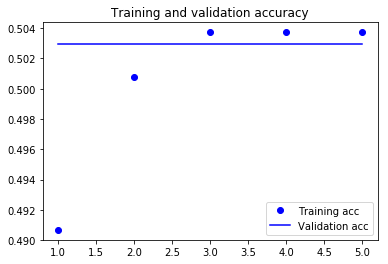

In [28]:
# your code here
# plot the accuracy rates for each epoch on training and validation data

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### LSTM [10 points] 

i) [2 point] Now built a LSTM model by replacing the simple RNN layter in the above model with a LSTM layer. Print a summary of the LSTM model.

In [29]:
# your code here
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
rnn_model = Sequential()
rnn_model.add(Embedding(max_words, embedding_dim))
rnn_model.add(LSTM(embedding_dim))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.layers[0].trainable = False
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 33,089
Non-trainable params: 640,000
_________________________________________________________________


ii) [2 point] Train the LSTM model with the same specifications in the simple RNN model. Again, plot the training and validation accuracy for each epoch.

Train on 2680 samples, validate on 670 samples
Epoch 1/5
2680/2680 [==============================] - 15s 6ms/step - loss: 0.6937 - acc: 0.4981 - val_loss: 0.6936 - val_acc: 0.4970
Epoch 2/5
2680/2680 [==============================] - 14s 5ms/step - loss: 0.6934 - acc: 0.4963 - val_loss: 0.6935 - val_acc: 0.5015
Epoch 3/5
2680/2680 [==============================] - 14s 5ms/step - loss: 0.6928 - acc: 0.5093 - val_loss: 0.6935 - val_acc: 0.4821
Epoch 4/5
2680/2680 [==============================] - 14s 5ms/step - loss: 0.6926 - acc: 0.5119 - val_loss: 0.6937 - val_acc: 0.4896
Epoch 5/5
2680/2680 [==============================] - 14s 5ms/step - loss: 0.6921 - acc: 0.5228 - val_loss: 0.6938 - val_acc: 0.4851


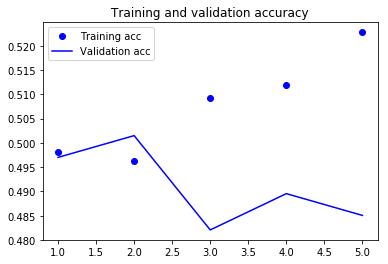

In [30]:
# your code here
rnn_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = rnn_model.fit(x_train, y_train,
                        validation_split=0.2,
                        epochs=5,
                        batch_size=32)
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

iii) [6 points] In the previous models, we only use the top 5000 tweets. Now use the whole dataset, split it into training (67%) and validation (33%) set, and train the same LSTM model on the new traning data. plot the training and validation accuracy for each epoch.

In [33]:
# your code here
%time
rnn_model = Sequential()
rnn_model.add(Embedding(max_words, embedding_dim))
rnn_model.add(LSTM(embedding_dim))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.summary()

rnn_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = rnn_model.fit(x_train, y_train,
                        validation_split=0.2,
                        epochs=5,
                        batch_size=1024) 

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________
Train on 2680 samples, validate on 670 samples
Epoch 1/5
2680/2680 [==============================] - 2s 892us/step - loss: 0.6945 - acc: 0.4914 - val_loss: 0.6934 - val_acc: 0.4970
Epoch 2/5
2680/2680 [==============================] - 1s 279us/step - loss: 0.6905 - acc: 0.5388 - val_loss: 0.6934 - val_acc: 0.5030
Epoch 3/5
2680/2680

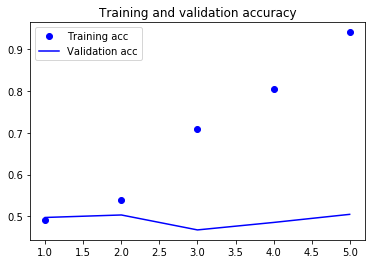

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### Results Comparision [5 points]

1\. [2 points] Compare the simple RNN model and the LSTM model (trained on the 5000 tweets sample). Which one has a better performance? Why does this one outperform the other one?

LSTM has the best performance, because it performs better in Gradient descent. 

2\. [3 points] Compare the LSTM model trained on a 5000 tweets sample and the one trained on the whole dataset. What are the cost and the benefit of each case?

Training in the whole dataset will ensure the higher accuracy, but it will cause more cost. Therefore, sacrifie a bit accuracy to get less cost. Choosing 5000 samples is more reasonable in medium case.

# Part 4: Questionnaire [5 points]

Please answer this questionnaire: https://goo.gl/forms/eN6pUx6QPIg2K9w13